# 1. Import Libraries

In [ ]:
import os
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

import nltk
nltk.download(['stopwords','vader_lexicon','punkt','wordnet','punkt_tab'])
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Camille\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# 2. Load Datasets

In [13]:
df_lyrics = pd.read_csv('songs_with_attributes_and_lyrics.csv', index_col='id', usecols=['id','lyrics'])
df_artists = pd.read_csv('CLEANED_featured_Spotify_artist_info.csv')

# Convert feat_track_ids into list of tracks and explode into individual tracks
df_artists['feat_track_ids'] = df_artists['feat_track_ids'].apply(lambda x: x.replace(' ','').split(','))
df_artists = df_artists.explode('feat_track_ids').reset_index(drop=True)

display( 
    df_artists.head(),
    df_lyrics.head()
)

,dates,ids,names,monthly_listeners,popularity,followers,genres,first_release,last_release,num_releases,num_tracks,playlists_found,feat_track_ids
0,2024-04-01,01XYiBYaoMJcNhPokrg0l0,stayc,3049521.0,63,1782552,"k-pop, k-pop girl group",2020,2024,14,2,K-Pop ON! (온),0y0uzuB1HxljAY2j0tLETp
1,2024-04-01,099toTcKJoywTosZr2hHjy,langhorne slim,1060777.0,51,163686,"anti-folk, indie folk, modern folk rock, new a...",2008,2023,20,3,Sunrise Run,40rjypnguxfhPy4Bbv5SWc
2,2024-04-01,0BvkDsjIUla7X0k6CSWh1I,luke bryan,10460890.0,76,8487512,"contemporary country, country, country road, m...",2007,2023,20,6,Sunrise Run,386DfI5sZ0eJi1i6SZVqLw
3,2024-04-01,0CmvFWTX9zmMNCUi6fHtAx,the boyz,1285501.0,60,2845229,"k-pop, k-pop boy group",2020,2024,20,6,K-Pop ON! (온),6MEtGumgTXWquxH35osvEC
4,2024-04-01,0FRUZvZNPzM3YJMABJxf2K,wendy,1885379.0,62,907553,"k-pop, korean pop",2015,2024,20,2,K-Pop ON! (온),7b8SkcdeiTuo6FQXdPgPWW


,lyrics
id,
0Prct5TDjAnEgIqbxcldY9,"He said he came from Jamaica,\n he owned a cou..."
2ASl4wirkeYm3OWZxXKYuq,"Fucked a bitch, now she running with my kids\n..."
69lcggVPmOr9cvPx9kLiiN,"Oh, my God, I'm going crazy\n"
4U7dlZjg1s9pjdppqZy0fm,Continuamente se extraña la gente si no puede ...
4v1IBp3Y3rpkWmWzIlkYju,Continuamente se extraña la gente si no puede ...


# 3. Data Wrangling and Cleaning

## 3.1. Clean null and duplicated lyrics

In [14]:
# Drop songs with no lyrics
df_lyrics = df_lyrics.dropna()
df_lyrics.shape

(955307, 1)

In [15]:
# Drop songs with duplicate lyrics (since we cannot know which song-lyric is the original)
df_lyrics = df_lyrics.drop_duplicates('lyrics', keep=False)
df_lyrics.shape

(748658, 1)

## 3.2. Merge song metadata with acoustics and lyrics

In [16]:
df_merged = df_artists.join(df_lyrics, on='feat_track_ids', how='inner')

df_merged.shape

(9601, 14)

# 4. Preprocessing

## 4.1. Stopwords

In [17]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
# Extend stopwords to remove other common stopwords, musical terms and slangs 
stop_words.extend([
    'verse', 'chorus', 'i"ll', 'intro', 'outro', 'or', 'm', 'ma', 'ours', 'against', 'nor','wasn', 'hasn', 'my', 'had', 'didn', 'isn', 'did', 'aren', 'those', 'than', 'man'
    "mustn't", "you've", 'to', 'she', 'having', "haven't", 'into', 't', 'll', 'himself', 'do', "that'll", 'so', 'of', 'on', 'very', 'for', 'out', 'were', 
    'should', 'they', 'ain', "should've", 'you', "didn't", 'yours', 'was', 'our','can', 'myself', "shouldn't", 'have', 'up', 'mightn', "you'll", 'any', 
    'itself', 'hadn', 'him', 'doesn', 'weren', 'y', 'being', "don't", 'them', 'are','and', 'that', 'your', 'yourself', 'their', 'some', 'ourselves', 've', 
    'doing', 'been', 'shouldn', 'yourselves', "mightn't", 'most', 'because','few', 'wouldn', "you'd", 'through', "you're", 'themselves', 'an', 'if',
     "wouldn't", 'its', 'other', "won't", "wasn't", "she's", 'we', 'shan',"weren't",'don',"hadn't", 'this', 'off', 'while', 'a', 'haven', 'her', 
    'theirs', 'all', "hasn't", "doesn't", 'about', 'then', 'by','such', 'but', 'until', 'each', 'there', "aren't", 'with', 'not', "shan't", 'hers', 'it', 
    'too', 'i', 'at', 'is', 'as', 'me', 'herself', 's', 'the', 'where', 'am', 'has', 'over', "couldn't", 'when', 'does', 'mustn','re', 'no', 'in', 'who', 
    'd', 'own', 'he', 'be', "isn't", 'his', 'these', 'same', 'whom', 'will', 'needn','couldn', 'from',  "it's", 'o', 'yeah','ya','na','wan','uh','gon',
    'ima','mm','uhhuh','bout','em','nigga','niggas','got','ta','lil','ol','hey','oooh','ooh','oh','youre','dont','im','youve','ive','theres','ill','yaka',
    'lalalala','la','da','di','yuh', 'shawty','oohooh','shoorah','mmmmmm','ook','bidibambambambam','shh','bro','ho','aint','cant','know','bambam','shitll','tonka','u','y'
])

stop_words = set(stop_words)

In [19]:
# Pre-compile the regex pattern for removing escaped new line characters
newline_pattern = re.compile(r'\\n')

# Initialize lemmatizer 
lemmatizer = WordNetLemmatizer()

def preprocess_lyrics(lyrics):
    # Remove escaped new line character
    lyrics = newline_pattern.sub(' ', str(lyrics))
    
    # Tokenization
    tokens = word_tokenize(lyrics)
    
    # Process tokens: remove punctuation, convert to lowercase, remove stopwords, and lemmatize
    processed_tokens = [
        lemmatizer.lemmatize(word.lower())
        for word in tokens if word.isalpha() and word.lower() not in stop_words
    ]
    
    return ' '.join(processed_tokens)

In [20]:
df_merged['cleaned_lyrics'] = df_merged['lyrics'].apply(preprocess_lyrics)

In [21]:
# try:
#     # Try to read the cleaned data from a CSV file
#     df_merged = pd.read_csv("cleaned_song_data.csv")
# except FileNotFoundError:
#     # If the file is not found, process the data    
#     df_merged['cleaned_lyrics'] = df_merged['lyrics'].apply(preprocess_lyrics)
    
#     # Save the dataframe with the cleaned lyrics to a CSV file for future use 
#     # This avoids the need to reprocess the lyrics in subsequent runs
#     df_merged.to_csv("cleaned_song_data.csv", index=None)

In [22]:
df_merged[['lyrics','cleaned_lyrics']].head()

,lyrics,cleaned_lyrics
1,Here we are\n Extending into shooting stars\n ...,extending shooting star house car way move bel...
2,"Hey baby, it's been a minute since\n Me and yo...",baby minute since caught little wild young kin...
5,My pain is self-chosen\n \n At least so the pr...,pain least prophet say could either burn cut p...
6,I don't know anything\n I don't know anything\...,anything anything anything anything anything a...
9,Summer nights and long warm days\n Are stolen ...,summer night long warm day stolen old moon fal...


# 5. Data Visualization

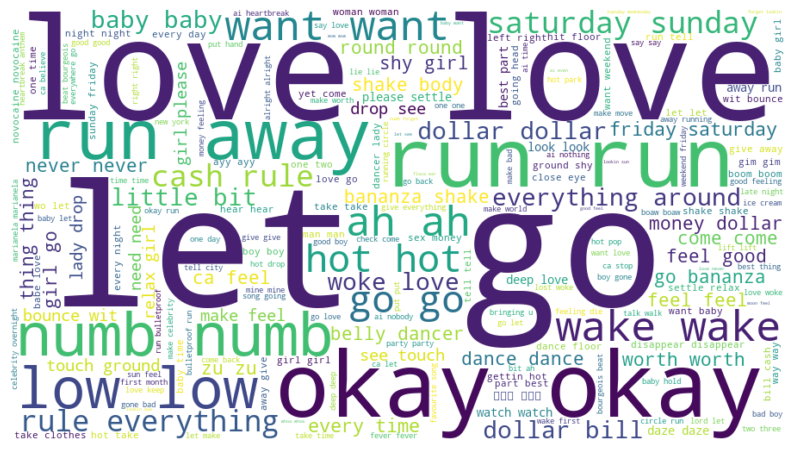

In [23]:
all_text = ' '.join(df_merged['cleaned_lyrics'])

wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 6. Sentiment Analysis

## 6.1. Using Vader

In [24]:
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(lyrics):
    scores = analyzer.polarity_scores(lyrics)
    compound_score = scores['compound']
    if compound_score > 0:
        sentiment = 'positive'
    elif compound_score < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return compound_score, sentiment

In [25]:
view_cols = ['names', 'genres', 'popularity', 'cleaned_lyrics', 'vader_compound_score', 'vader_sentiment']

df_merged[['vader_compound_score', 'vader_sentiment']] = df_merged['cleaned_lyrics'].apply(lambda x: pd.Series(vader_sentiment(x)))
df_merged[view_cols].head()

,names,genres,popularity,cleaned_lyrics,vader_compound_score,vader_sentiment
1,langhorne slim,"anti-folk, indie folk, modern folk rock, new a...",51,extending shooting star house car way move bel...,0.9509,positive
2,luke bryan,"contemporary country, country, country road, m...",76,baby minute since caught little wild young kin...,0.9924,positive
5,mad season,"alternative metal, alternative rock, blues roc...",49,pain least prophet say could either burn cut p...,-0.9565,negative
6,mad season,"alternative metal, alternative rock, blues roc...",49,anything anything anything anything anything a...,0.9682,positive
9,chris cornell,"alternative metal, alternative rock, grunge, h...",59,summer night long warm day stolen old moon fal...,-0.9776,negative


## 6.2. Using TextBlob

In [26]:
def blob_sentiment(lyrics):
    blob = TextBlob(lyrics)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    return polarity, sentiment

In [27]:
view_cols = ['names', 'genres', 'popularity', 'cleaned_lyrics', 'vader_compound_score', 'vader_sentiment', 'textblob_polarity', 'textblob_sentiment']

df_merged[['textblob_polarity', 'textblob_sentiment']] = df_merged['cleaned_lyrics'].apply(lambda x: pd.Series(blob_sentiment(x)))
df_merged[view_cols].head()

,names,genres,popularity,cleaned_lyrics,vader_compound_score,vader_sentiment,textblob_polarity,textblob_sentiment
1,langhorne slim,"anti-folk, indie folk, modern folk rock, new a...",51,extending shooting star house car way move bel...,0.9509,positive,0.125000,positive
2,luke bryan,"contemporary country, country, country road, m...",76,baby minute since caught little wild young kin...,0.9924,positive,0.043981,positive
5,mad season,"alternative metal, alternative rock, blues roc...",49,pain least prophet say could either burn cut p...,-0.9565,negative,0.150000,positive
6,mad season,"alternative metal, alternative rock, blues roc...",49,anything anything anything anything anything a...,0.9682,positive,-0.066061,negative
9,chris cornell,"alternative metal, alternative rock, grunge, h...",59,summer night long warm day stolen old moon fal...,-0.9776,negative,-0.089130,negative


## 6.3. Visualizing Sentiment Distribution

In [28]:
def plot_sentiment_distribution(df, sentiment_column, title):
    sentiment_counts = df[sentiment_column].value_counts()
    sentiment_labels = sentiment_counts.index
    sentiment_sizes = sentiment_counts.values

    # Custom colors for the pie chart
    plot_colors = ['#FF6F61', '#008080', '#FFA500'] 

    plt.figure(figsize=(5, 5))
    patches, texts, autotexts = plt.pie(sentiment_sizes, autopct='%1.1f%%', startangle=140, colors=plot_colors)
    
    plt.legend(patches, sentiment_labels, loc="best")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(f'Sentiment Distribution for {title}')
    plt.show()

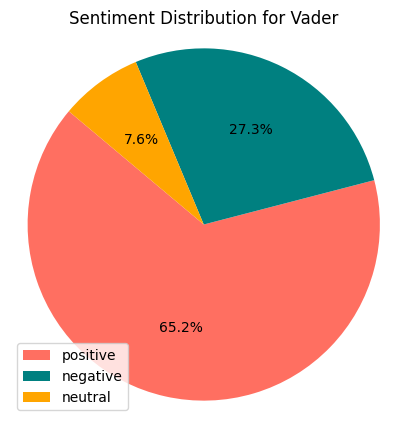

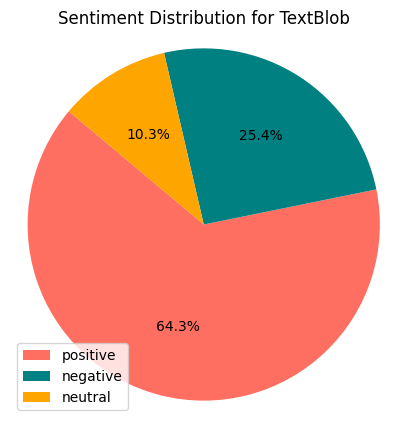

In [29]:
plot_sentiment_distribution(df_merged, 'vader_sentiment', 'Vader')
plot_sentiment_distribution(df_merged, 'textblob_sentiment', 'TextBlob')

## 6.4. Exploring Top 20 Positive and Negative Sentiment Songs

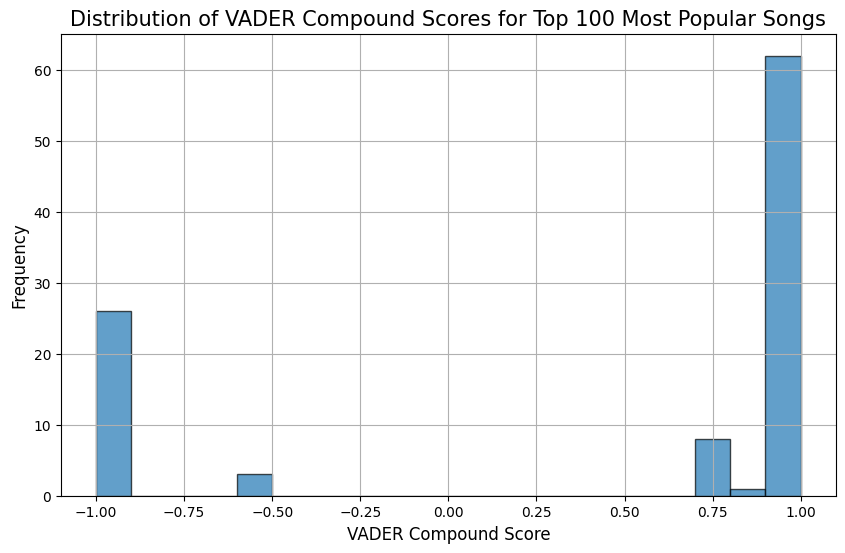

In [30]:
import matplotlib.pyplot as plt

# Sélectionner les 100 chansons les plus populaires
top_100_songs = df_merged[['popularity', 'vader_compound_score']].nlargest(100, 'popularity')

# Afficher la distribution du vader_compound_score pour les 100 chansons les plus populaires
plt.figure(figsize=(10, 6))
plt.hist(top_100_songs['vader_compound_score'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of VADER Compound Scores for Top 100 Most Popular Songs', fontsize=15)
plt.xlabel('VADER Compound Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()

In [31]:
def plot_wordclouds(df,number):
    # Filter top 10 positive and negative songs for VADER
    top_vader_positive = df[df['vader_sentiment'] == 'positive'].nlargest(number, 'vader_compound_score')['cleaned_lyrics']
    top_vader_negative = df[df['vader_sentiment'] == 'negative'].nsmallest(number, 'vader_compound_score')['cleaned_lyrics']
    
    # Filter top 10 positive and negative songs for TextBlob
    top_textblob_positive = df[df['textblob_sentiment'] == 'positive'].nlargest(number, 'textblob_polarity')['cleaned_lyrics']
    top_textblob_negative = df[df['textblob_sentiment'] == 'negative'].nsmallest(number, 'textblob_polarity')['cleaned_lyrics']
    
    # Generate word clouds
    vader_positive_text = ' '.join(top_vader_positive)
    vader_negative_text = ' '.join(top_vader_negative)
    textblob_positive_text = ' '.join(top_textblob_positive)
    textblob_negative_text = ' '.join(top_textblob_negative)
    
    vader_positive_wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(vader_positive_text)
    vader_negative_wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(vader_negative_text)
    textblob_positive_wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(textblob_positive_text)
    textblob_negative_wordcloud = WordCloud(width=900, height=500, background_color='white', random_state=42).generate(textblob_negative_text)
    
    # Plot the word clouds
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    
    axes[0, 0].imshow(vader_positive_wordcloud, interpolation='bilinear')
    axes[0, 0].set_title(f'Top {number} Positive Songs (VADER)', fontsize=20)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(textblob_positive_wordcloud, interpolation='bilinear')
    axes[0, 1].set_title(f'Top {number} Positive Songs (TextBlob)', fontsize=20)
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(vader_negative_wordcloud, interpolation='bilinear')
    axes[1, 0].set_title(f'Top {number} Negative Songs (VADER)', fontsize=20)
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(textblob_negative_wordcloud, interpolation='bilinear')
    axes[1, 1].set_title(f'Top {number} Negative Songs (TextBlob)', fontsize=20)
    axes[1, 1].axis('off')
    
    plt.subplots_adjust(wspace=-1, hspace=-1)
    fig.tight_layout()
    
    # Save the figure
    fig.savefig('wordclouds.png', bbox_inches='tight')
    
    plt.show()

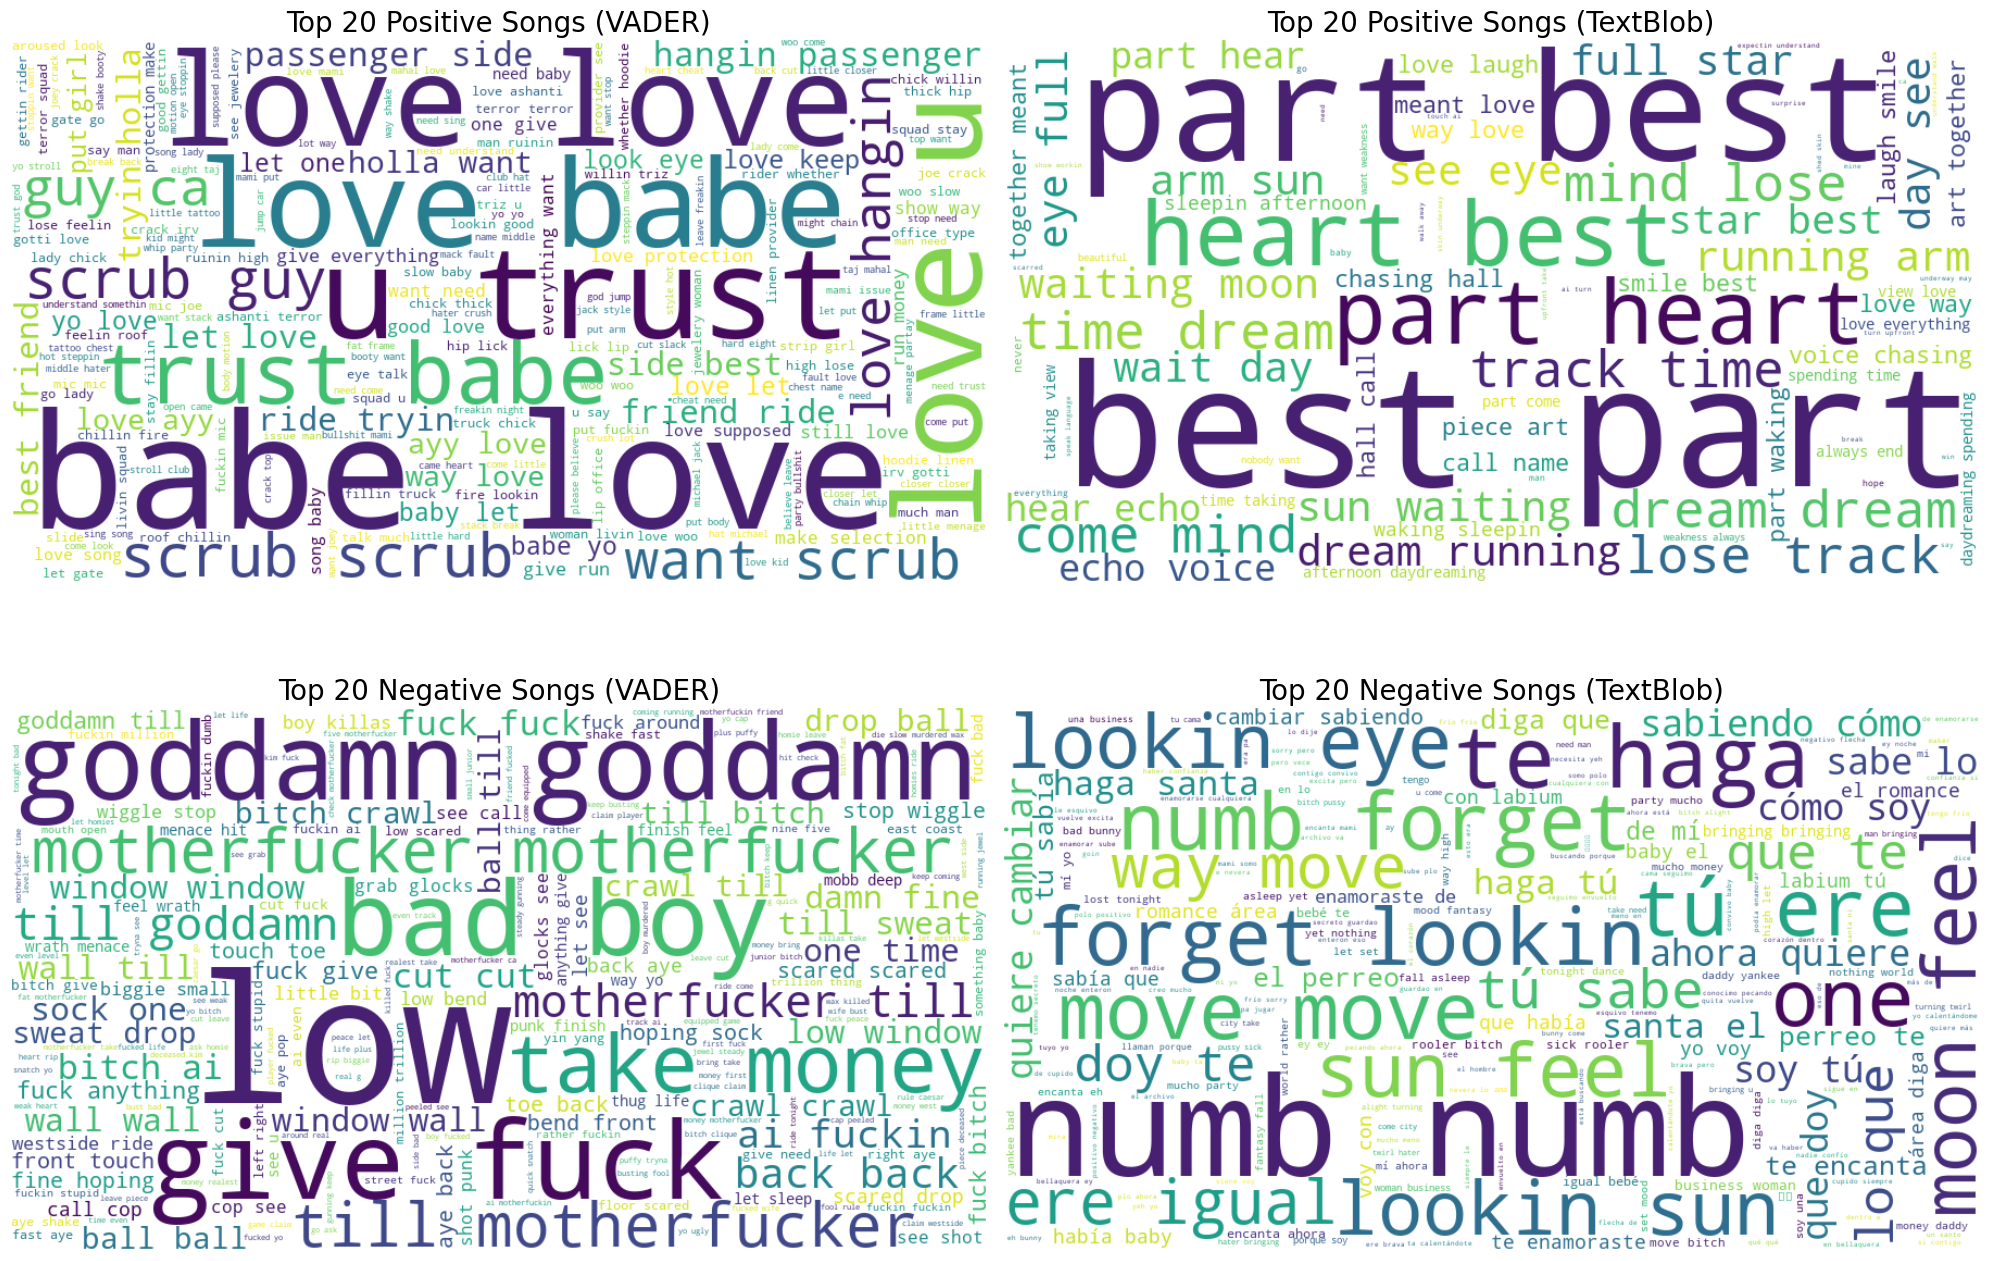

In [32]:
# Plot the word clouds
plot_wordclouds(df_merged,20)

# 7. Machine Learning

Erreur quadratique moyenne de la régression linéaire: 98.06998614857626
Score R2 de la régression linéaire: 0.5817531813220951
Erreur quadratique moyenne de la régression polynomiale: 60.82252606328743
Score R2 de la régression polynomiale: 0.7406053673609778


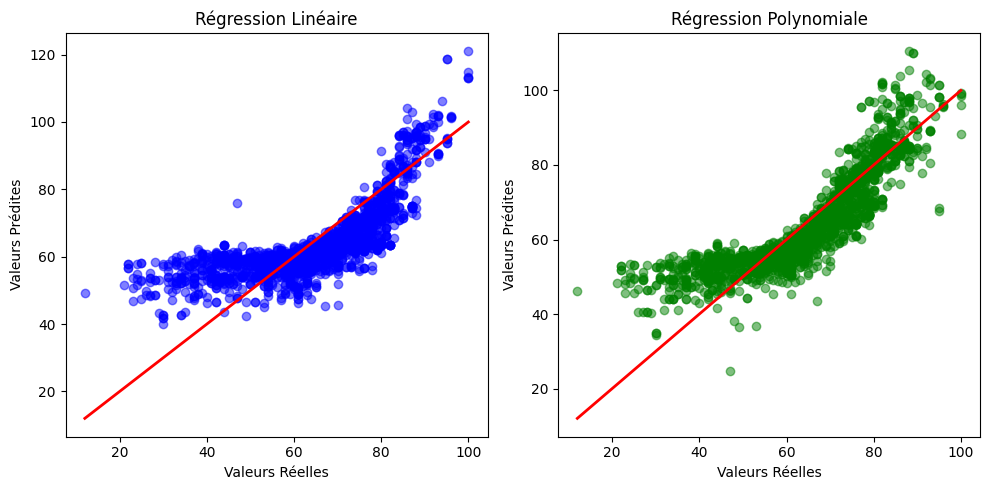

In [33]:
# Encode some features
# merged_df['explicit_label'] = merged_df['explicit'].apply(lambda x: 1 if x else 0)
# merged_df['song_type_label'] = merged_df['song_type'].apply(lambda x: 1 if x == 'Solo' else 0)
df_merged['sentiment_label'] = df_merged['vader_sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Select the features
X = df_merged[['monthly_listeners', 'followers', 'first_release',
       'last_release', 'num_releases', 'num_tracks','vader_compound_score','sentiment_label']].apply(pd.to_numeric, errors='coerce')

# Select the target
y = pd.to_numeric(df_merged['popularity'], errors='coerce')

data = pd.concat([X, y], axis=1)
data = data.dropna()

# Séparer les données nettoyées en X et y
X = data[['monthly_listeners', 'followers', 'first_release',
       'last_release', 'num_releases', 'num_tracks','vader_compound_score','sentiment_label']]
y = data['popularity']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Régression linéaire
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

# Régression polynomiale (degré=2 en exemple)
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# Modèle de régression polynomiale
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
y_pred_poly = poly_reg.predict(X_test_poly)

# Évaluation des deux modèles
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)
mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)

print("Erreur quadratique moyenne de la régression linéaire:", mse_lin)
print("Score R2 de la régression linéaire:", r2_lin)
print("Erreur quadratique moyenne de la régression polynomiale:", mse_poly)
print("Score R2 de la régression polynomiale:", r2_poly)

# Visualisation
plt.figure(figsize=(10, 5))

# Tracer les résultats de la régression linéaire
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lin, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.title('Régression Linéaire')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')

# Tracer les résultats de la régression polynomiale
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_poly, color='green', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
plt.title('Régression Polynomiale')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Valeurs Prédites')

plt.tight_layout()
plt.show()

Régression Linéaire - MSE: 98.0700, R2: 0.5818
Régression Polynomiale (degré 2) - MSE: 60.8225, R2: 0.7406


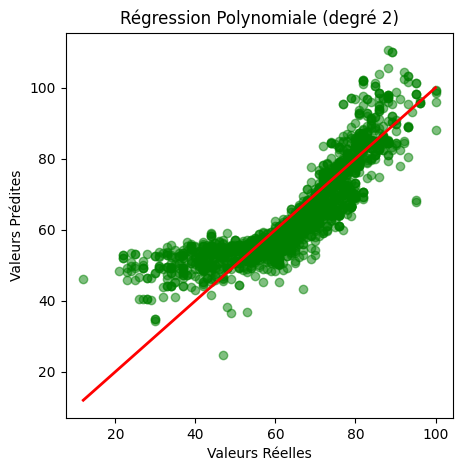

Régression Polynomiale (degré 3) - MSE: 47.3641, R2: 0.7980


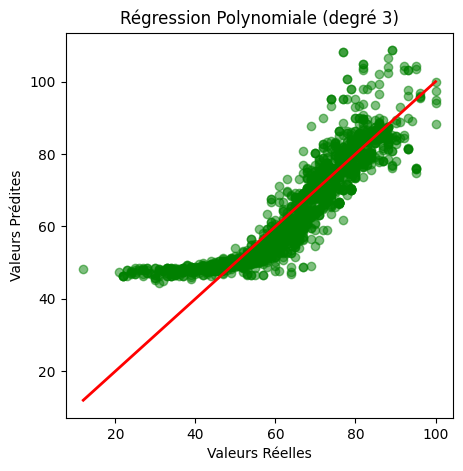

Régression Polynomiale (degré 4) - MSE: 80.0169, R2: 0.6587


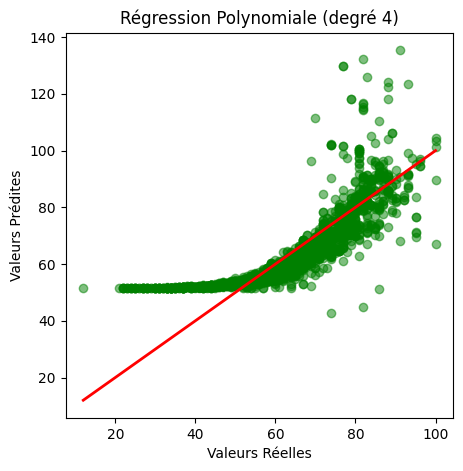

Régression Polynomiale (degré 5) - MSE: 124.6191, R2: 0.4685


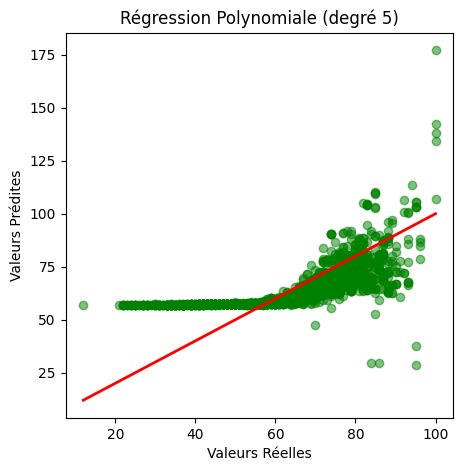

In [34]:
# S'assurer que toutes les colonnes de caractéristiques sont numériques
X = df_merged[['monthly_listeners', 'followers', 'first_release',
       'last_release', 'num_releases', 'num_tracks','vader_compound_score','sentiment_label']].apply(pd.to_numeric, errors='coerce')

# Convertir la colonne 'streams' en numérique
y = pd.to_numeric(df_merged['popularity'], errors='coerce')

# Supprimer les lignes contenant des valeurs NaN dans X et y
data = pd.concat([X, y], axis=1).dropna()

# Séparer les données nettoyées en X et y
X = data[['monthly_listeners', 'followers', 'first_release',
       'last_release', 'num_releases', 'num_tracks','vader_compound_score','sentiment_label']]
y = data['popularity']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Régression linéaire de référence
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print(f"Régression Linéaire - MSE: {mse_lin:.4f}, R2: {r2_lin:.4f}")

# Tester plusieurs degrés de régression polynomiale
for degree in range(2, 6):  # Essayer des degrés de 2 à 5
    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    X_test_poly = poly_features.transform(X_test)
    
    # Ajuster le modèle de régression polynomiale
    poly_reg = LinearRegression()
    poly_reg.fit(X_train_poly, y_train)
    y_pred_poly = poly_reg.predict(X_test_poly)
    
    # Évaluer le modèle
    mse_poly = mean_squared_error(y_test, y_pred_poly)
    r2_poly = r2_score(y_test, y_pred_poly)
    
    print(f"Régression Polynomiale (degré {degree}) - MSE: {mse_poly:.4f}, R2: {r2_poly:.4f}")
    
    # Visualiser les résultats
    plt.figure(figsize=(5, 5))
    plt.scatter(y_test, y_pred_poly, color='green', alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linewidth=2)
    plt.title(f'Régression Polynomiale (degré {degree})')
    plt.xlabel('Valeurs Réelles')
    plt.ylabel('Valeurs Prédites')
    plt.show()


# 8. Classifiers

### Correlation

Index(['monthly_listeners', 'popularity', 'followers', 'first_release',
       'last_release', 'num_releases', 'num_tracks', 'vader_compound_score',
       'textblob_polarity', 'sentiment_label'],
      dtype='object')


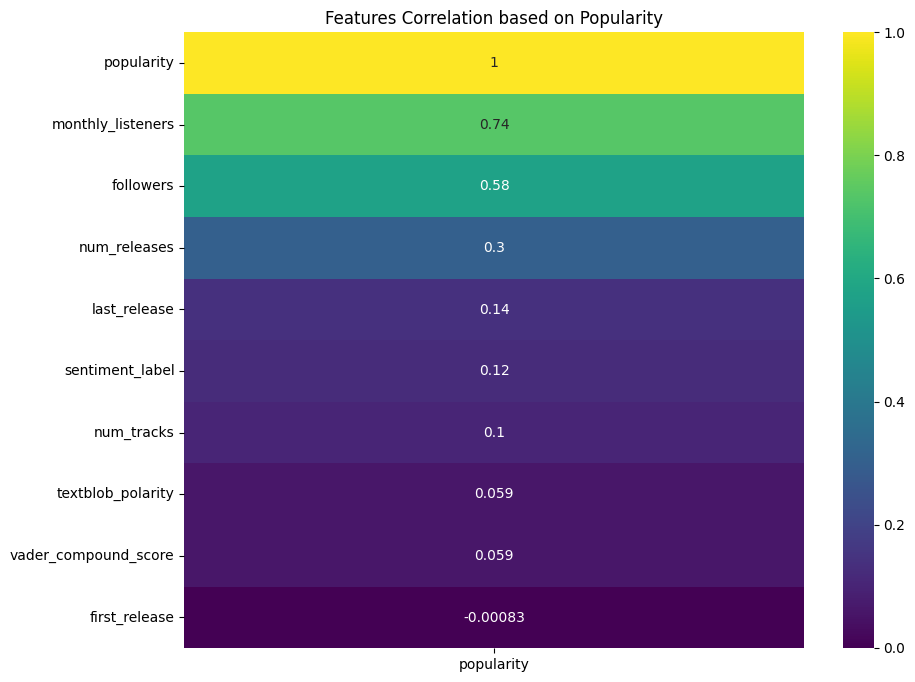

In [44]:
# Convertir la colonne 'streams' en type numérique
df_merged['popularity'] = pd.to_numeric(df_merged['popularity'], errors='coerce')

# Sélection des colonnes numériques pour l'analyse
numerical_df = df_merged.select_dtypes(include=['float64', 'int64'])

# Check column names
print(numerical_df.columns)

# Ensure 'streams' column exists
if 'popularity' not in numerical_df.columns:
    raise KeyError("'Popularity' column not found in the DataFrame. Please check the column name.")

# Corrélation avec la target 'streams'
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df.corr()[['popularity']].sort_values(by='popularity', ascending=False), annot=True, cmap='viridis')
plt.title('Features Correlation based on Popularity')
plt.show()

### Random Forest

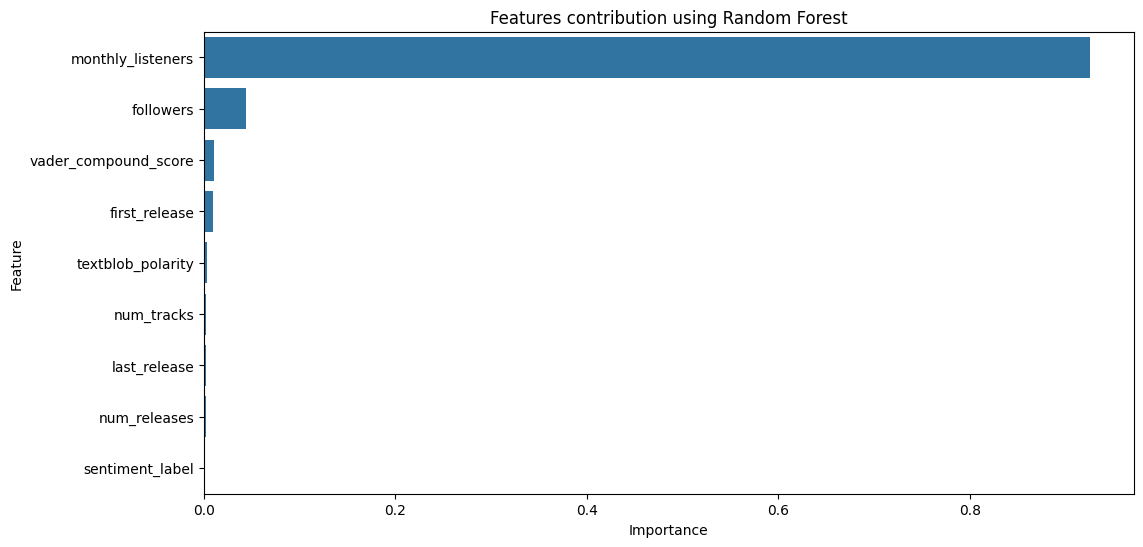

Les features les plus pertinentes selon RFE: Index(['monthly_listeners', 'followers', 'first_release',
       'vader_compound_score', 'textblob_polarity'],
      dtype='object')


In [36]:
# Préparer les données pour l'entraînement (target: 'streams')
X = numerical_df.drop(columns=['popularity'])
y = numerical_df['popularity']

# Drop rows with NaN values in the target variable
X = X[y.notna()]
y = y.dropna()

# Utilisation de Random Forest pour déterminer l'importance des features
model = RandomForestRegressor(random_state=42, n_estimators=200)
model.fit(X, y)

# Importance des features
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Afficher l'importance des features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Features contribution using Random Forest')
plt.show()

# Utilisation de la méthode RFE pour la sélection des features
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y)
selected_features = X.columns[rfe.support_]

print(f'Les features les plus pertinentes selon RFE: {selected_features}')

### DECISION TREE

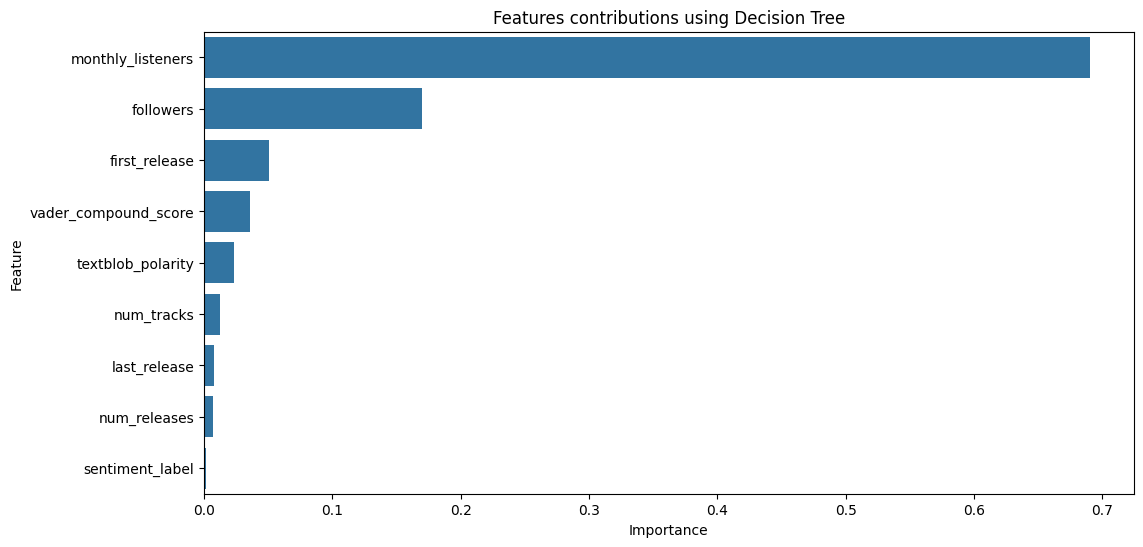

Les features les plus pertinentes selon RFE: Index(['monthly_listeners', 'followers', 'first_release',
       'vader_compound_score', 'textblob_polarity'],
      dtype='object')


In [37]:
# Préparer les données pour l'entraînement (target: 'streams')
X = numerical_df.drop(columns=['popularity'])
y = numerical_df['popularity']

# Drop rows with NaN values in the target variable
X = X[y.notna()]
y = y.dropna()

# Convert continuous target variable to discrete classes
y_discrete = pd.qcut(y, q=4, labels=False)

# Utilisation de DecisionTreeClassifier pour déterminer l'importance des features
model = tree.DecisionTreeClassifier()
model.fit(X, y_discrete)

# Importance des features
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Afficher l'importance des features
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Features contributions using Decision Tree')
plt.show()

# Utilisation de la méthode RFE pour la sélection des features
rfe = RFE(model, n_features_to_select=5)
rfe.fit(X, y_discrete)
selected_features = X.columns[rfe.support_]

print(f'Les features les plus pertinentes selon RFE: {selected_features}')

In [ ]:
# Convert continuous target variable to discrete classes
y_train_discrete = pd.qcut(y_train, q=4, labels=False)
y_test_discrete = pd.qcut(y_test, q=4, labels=False)

# Entraîner un modèle de classification (Decision Tree)
dt_model = tree.DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train_discrete)

# Faire des prédictions
y_pred_dt = dt_model.predict(X_test)

# Calculer le F1 score pour Decision Tree
f1_dt = f1_score(y_test_discrete, y_pred_dt, average='weighted')
print(f"Decision Tree F1 Score: {f1_dt:.4f}")

# Entraîner un modèle de classification (Random Forest)
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train_discrete)

# Faire des prédictions
y_pred_rf = rf_model.predict(X_test)

# Calculer le F1 score pour Random Forest
f1_rf = f1_score(y_test_discrete, y_pred_rf, average='weighted')
print(f"Random Forest F1 Score: {f1_rf:.4f}")

Decision Tree F1 Score: 0.9589
Random Forest F1 Score: 0.9745


# 9. DEEP LEARNING 

## Neural Network

In [38]:
# Charger les données
data = df_merged

# Afficher les types de données des colonnes
print(data.dtypes)

# Identifier les colonnes non numériques
non_numeric_columns = data.select_dtypes(include=['object']).columns
# Ensure 'streams' column exists before conversion
if 'popularity' in data.columns:
    data['popularity'] = pd.to_numeric(data['popularity'], errors='coerce')
else:
    raise KeyError("'popularity' column not found in the DataFrame. Please check the column name.")

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normaliser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Définir l'architecture du modèle neuronal pour la régression
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # Utiliser une activation linéaire pour la régression

# Compiler le modèle pour la régression
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Entraîner le modèle
model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.2)

# Évaluer le modèle
loss, mae = model.evaluate(X_test, y_test)
print(f'Mean Absolute Error: {mae:.2f}')

# Faire des prédictions
predictions = model.predict(X_test)

# Afficher l'erreur quadratique moyenne des prédictions
mse = mean_squared_error(y_test, predictions)
print(f'Erreur quadratique moyenne (MSE): {mse:.2f}')

r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")

dates                    object
ids                      object
names                    object
monthly_listeners       float64
popularity                int64
followers                 int64
genres                   object
first_release             int64
last_release              int64
num_releases              int64
num_tracks                int64
playlists_found          object
feat_track_ids           object
lyrics                   object
cleaned_lyrics           object
vader_compound_score    float64
vader_sentiment          object
textblob_polarity       float64
textblob_sentiment       object
sentiment_label           int64
dtype: object


c:\Users\Camille\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2347.9749 - mae: 41.0338 - val_loss: 148.3681 - val_mae: 9.5439
Epoch 2/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 145.7206 - mae: 9.4353 - val_loss: 110.5375 - val_mae: 8.1978
Epoch 3/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 114.2863 - mae: 8.3967 - val_loss: 98.8379 - val_mae: 7.6949
Epoch 4/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 103.5524 - mae: 7.8922 - val_loss: 86.2294 - val_mae: 7.2826
Epoch 5/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 81.7162 - mae: 6.9531 - val_loss: 54.4048 - val_mae: 5.6356
Epoch 6/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 51.8582 - mae: 5.3887 - val_loss: 45.4571 - val_mae: 5.1516
Epoch 7/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 44.1001 - mae: 4.8367 - val_loss: 35.3143 - val_mae: 4.2435
Epoch 8/50
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 35.6792 - mae: 4.3363 - val_loss: 32.6342 - val_mae: 4.2171
Epoch 9/50
615/615 ━━━━━━━━━━━━━

## Extreme Gradient Boosting Machines

### Raw Gradient Boosting Machines

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler


# print(data[['popularity']].head())

# Convert the 'streams' column to numeric values and drop rows with conversion errors
data['popularity'] = pd.to_numeric(data['popularity'], errors='coerce')
data = data.dropna(subset=['popularity'])

# Ensure all feature columns are numeric
important_features = ['monthly_listeners', 'followers', 'first_release',
       'last_release', 'num_releases', 'num_tracks','vader_compound_score','sentiment_label']

# Convert features to numeric, coerce errors to NaN
data[important_features] = data[important_features].apply(pd.to_numeric, errors='coerce')

# Convert the target variable 'streams' to numeric
data['popularity'] = pd.to_numeric(data['popularity'], errors='coerce')

# Drop rows with NaN values in either the features or target variable
data = data.dropna(subset=important_features + ['popularity'])

X = data[important_features]
y = data['popularity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the GBM model
gbm = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# Train the model
gbm.fit(X_train, y_train)

# Make predictions
y_pred = gbm.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


Mean Squared Error: 7.820459575708062
R-squared: 0.9666474681337911


### Improved Gradient Boosting Machines

In [40]:
# Convert the 'streams' column to numeric values and drop rows with conversion errors
data['popularity'] = pd.to_numeric(data['popularity'], errors='coerce')
data = data.dropna(subset=['popularity'])

# Define important features
important_features = ['monthly_listeners', 'followers', 'first_release',
       'last_release', 'num_releases', 'num_tracks','vader_compound_score','sentiment_label']

# Convert features to numeric, coerce errors to NaN
data[important_features] = data[important_features].apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values in either the features or target variable
data = data.dropna(subset=important_features + ['popularity'])

# Feature matrix and target vector
X = data[important_features]
y = data['popularity']

# Apply log transformation to the target variable to handle large variations in values
y = np.log1p(y)  # log1p is used to avoid issues with zeros (it calculates log(1 + y))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Gradient Boosting Regressor with default parameters
gbm = GradientBoostingRegressor(random_state=42)

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Perform Grid Search with Cross Validation to find the best parameters
grid_search = GridSearchCV(gbm, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best estimator from the grid search
best_gbm = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Train the best model
best_gbm.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred_log = best_gbm.predict(X_test_scaled)

# Convert predictions back from log scale
y_pred = np.expm1(y_pred_log)  # This is the inverse of the log1p transformation

# Convert y_test back from log scale for evaluation
y_test_original = np.expm1(y_test)

# Evaluate the model
mse = mean_squared_error(y_test_original, y_pred)
print(f"Mean Squared Error: {mse}")

r2 = r2_score(y_test_original, y_pred)
print(f"R-squared: {r2}")

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Mean Squared Error: 3.256521517657075
R-squared: 0.9861116553778978
